In [2]:
%reset -f 
%matplotlib inline
import numpy as np
from matplotlib.animation import FuncAnimation
import os, sys, importlib, json, itertools
from datetime import datetime
from IPython.display import HTML, display

# Import the aif module
pwd = os.path.abspath('') + "/"
sys.path.insert(1, pwd + '/aif_catkin_ws/aif_gazebo/scripts/')
import aif_functions_isobeliefs_adaptable as aif # Interchangeable with aif_functions_isobeliefs and aif_functions_isobeliefs_mcts
# import aif_catkin_ws.aif_gazebo.scripts.aif_functions_isobeliefs_adaptable as aif # Interchangeable with aif_functions_isobeliefs and aif_functions_isobeliefs_mcts
importlib.reload(aif)

import os
print(os.cpu_count())

8


Iteration 69: Agents have selected goals [1, 1, 1]. Execution Time: 0.015344858169555664s Agents have converged to Goal 1 after 69 iterations. Use EP: False
Final Prior:  [array([[0.56010502, 0.43989498]]), array([[0.42620126, 0.57379874]]), array([[0.34489073, 0.65510927]])]
Agent Types:  ['B' 'A' 'B']
Image saved as:  c:\Users\qbr5kx\OneDrive - University of Virginia\Desktop\UVA\PhD Scratch\Active_Epistemic_Inference\aif_multi_robot/videos/two_goals_choice_ok_seed39_EPFalse_goalTypeconverge_20240605-104720.mp4


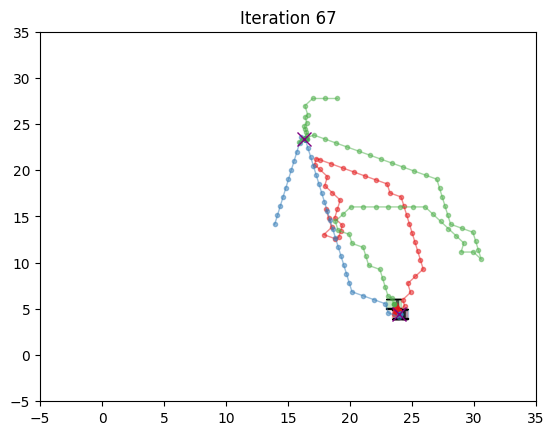

In [15]:
# Re-define the environment and simulation parameters here
interactive = False  # Set to True to display the animation in the notebook
use_ep = False  # Set to True to use EP, False to use the standard algorithm
convergence_type = 'converge'  # Set to 'converge' to check for convergence, 'exclusive' to check for separate goals
args = {}
# draft_results = []

random_seed = 39  # 1 right now is perfect
np.random.seed(random_seed)  # Set random seed
# Set random goals
env_size = 30  # Environment size
iterations_per_episode = 100  # Number of iterations per episode
num_goals = 2 # Number of goals
num_agents = 3  # Number of agents
list_types = ['A','B']
goals = np.random.uniform(1,env_size-1,size=(num_goals, 2))  # Goal positions
# goals = np.array([[0,0],[env_size-5,0]], dtype=float)  # Goal positions
agent_positions = np.hstack((np.random.uniform(0,env_size,size=(num_agents, 2)),np.zeros((num_agents,1))))  # Initial agent positions
number_of_heading_options = 8; number_of_velocity_options = 4
args = dict({
    'goals': goals, # Goal positions
    'agent_types': np.random.choice(list_types,num_agents), # Agent types
    'agent_positions': agent_positions, # Initial agent positions
    'velocity_options': np.linspace(0.0,1,number_of_velocity_options,endpoint=True), # Velocity options
    'num_heading_options': number_of_heading_options, # Number of heading options
    'heading_options': np.linspace(-np.pi,np.pi,number_of_heading_options,endpoint=True),
    'observation_error_std': 0.0, # Observation error standard deviation
    'num_actions': number_of_heading_options*number_of_velocity_options, # Number of actions
    'env_size': env_size, # Environment size
    'max_distance_measure': env_size + 20,
    'max_heading_measure': np.pi, # Maximum heading measure
    'prior': np.ones(goals.shape[0]) / goals.shape[0], # Prior belief
    'use_ep': use_ep, # Use epistemic planning (2nd order reasoning)
    'horizon': 5, # Horizon for free energy checking
    'mcts_iterations': 100, # Number of MCTS iterations
    'use_mcts': False,
    'use_threading': False, #TODO: Implement threading
    'convergence_type': convergence_type, # Convergence type
})

# Check convergence for different types of conergence criterion
if args['convergence_type'] == 'exclusive':
    tuple_elements = [i for i in range(goals.shape[0])]
    configurations = list(itertools.permutations(tuple_elements))
    args['reward_configs'] = configurations # Reward configurations if different goals
else:
    args['reward_configs'] = [tuple(np.repeat(i, num_agents)) for i in range(num_goals)]

# args['reward_configs'] = [(0,1,1), (1,0,1), (1,1,0)]

# args['reward_configs'] = [tuple(np.repeat(i, num_agents)) for i in range(num_goals)] # Reward configurations if all same goals
# Generate all permutations

# Run the simulation
results = aif.run_simulation(args, iterations_per_episode)
print("Final Prior: ", results['priors'])
print("Agent Types: ", args['agent_types'])

# Create animation
# results = json.loads(return_args)
plt_sim = aif.PlotSim(num_agents,goals,env_size,padding = 5)
ani = FuncAnimation(plt_sim.fig, plt_sim.update, frames=range(results['iteration']), init_func=plt_sim.init, fargs = (results['plot_args'],), blit=True, repeat=True)

# Save the animation as a video
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")

if results['converged'] == None and not interactive:
    filepath = pwd + "videos/two_goals_choice_NO_convergence_seed" + str(random_seed) + "_EP" + str(args['use_ep']) + "_goalType" + convergence_type + "_" + current_time + ".mp4"
    ani.save(filepath, writer='ffmpeg', fps=3, dpi=300)
    # Save location of the final image
    print("Image saved as: ", filepath)
elif not interactive:
    filepath = pwd + "videos/two_goals_choice_ok_seed" + str(random_seed) + "_EP" + str(args['use_ep']) + "_goalType" + convergence_type + "_" + current_time + ".mp4"
    ani.save(filepath, writer='ffmpeg', fps=3, dpi=300)
    # Save location of the final image
    print("Image saved as: ", filepath)
else:
    display(HTML(ani.to_jshtml())) # Use an interactive backend for animation



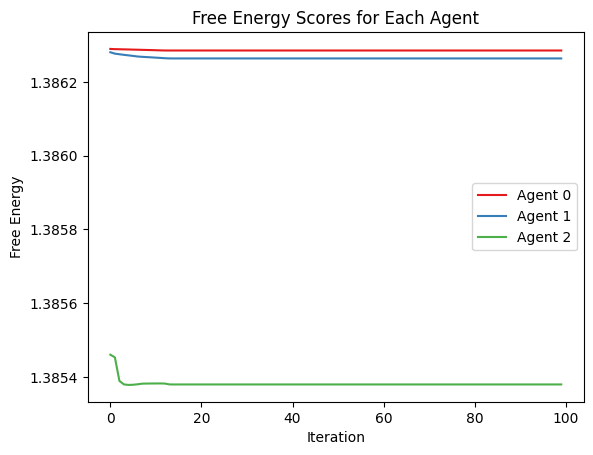

[(0, 0, 0), (1, 1, 1), (2, 2, 2), (3, 3, 3)]


In [148]:
avg_nrg_over_time = results['energy_scores']
num_frames = results['iteration']
energy_results, ending_energy = aif.parse_free_energy_scores(avg_nrg_over_time, num_frames)
aif.plot_energy(energy_results, num_agents)
print(args['reward_configs'])

In [ ]:
# Calculate distance to final goals
final_distances = np.zeros((num_agents, goals.shape[0]))
for i in range(num_agents):
    for j in range(goals.shape[0]):
        final_distances[i,j] = np.linalg.norm(results['positions'][i,:2] - goals[j,:])
print("Final distances: ", final_distances)


Final distances:  [[0.04272534 4.99155181]
 [0.04607108 5.04569454]]


In [ ]:
# Scratch code for testing

goals = np.array([[0,0],[0.,10.]])
my_pose = np.array([14.12709979, 12.76192634,  0.])
other_pose = np.array([6.30305407,  7.28140647,  0.])
saliences = np.zeros(goals.shape[0])
goal_azimuths = np.arctan2(goals[:, 1] - my_pose[1], goals[:, 0] - my_pose[0])
observed_azimuth = np.arctan2(other_pose[1] - my_pose[1], other_pose[0] - my_pose[0])
relative_azimuths = np.abs((goal_azimuths - observed_azimuth + np.pi) % (2 * np.pi) - np.pi)
azimuth_salience = 1./8 * np.exp(- relative_azimuths / np.pi)  # normalize and invert to make smaller angles more salient
saliences += azimuth_salience
# Compute if observed robot is heading towards the goal
# heading_to_goal = (np.arctan2(goals[:, 1] - observation['position'][1], goals[:, 0] - observation['position'][0]) - observation['heading'] + np.pi) % (2 * np.pi) - np.pi
# heading_salience = 1./8 * np.exp(- np.abs(heading_to_goal) / np.pi)
# saliences += heading_salience


print("Goal Azimuth: ", goal_azimuths)
print("Relative Azimuth: ", azimuth_salience)
print("Observed Azimuth: ", observed_azimuth)
print("Salience: ", saliences)
# print("Heading Salience: ", heading_salience)
print(np.exp(0.8/np.pi))

Goal Azimuth:  [-2.40692159 -2.9485224 ]
Relative Azimuth:  [0.1201765  0.10942825]
Observed Azimuth:  -2.5305504167886905
Salience:  [0.1201765  0.10942825]
1.2900073408606396


In [ ]:
poses = np.array([[0,0],[0,0]])+0.5
print(poses)
distance = sum(poses[i][dim] - poses[j][dim] for i in range(2) for j in range(2) if i != j for dim in range(2))
1e4 / (1+np.exp(100*(distance - 1.5)))

[[0.5 0.5]
 [0.5 0.5]]


10000.0